# EDA and Dataset Preparation

This notebook performs exploratory data analysis (EDA) and preprocessing on the wildlife detection dataset to ensure data quality and readiness for model training and evaluation.

## Main Steps
- **Load raw COCO-style annotations** for all dataset splits (`cis_val`, `cis_test`, `trans_val`, `trans_test`).
- **Check dataset structure**:
  - Verify image existence and dimensions.
  - Identify missing or corrupt images.
- **Analyze class distribution** across splits to detect imbalance (animals, vehicles, background).
- **Clean and filter annotations**:
  - Remove invalid bounding boxes.
  - Ensure category IDs and names are consistent.
  - Drop duplicates or heavily overlapping boxes if necessary.
- **Generate dataset statistics**:
  - Image counts per split.
  - Annotation counts per class.
  - Summary tables and plots.
- **Export cleaned COCO JSON files** for downstream use in detection and classification.

The cleaned datasets generated here are used as the standardized input for all later training and evaluation stages.


# Summary of dataset within all splits

In [18]:
import json, pathlib, pandas as pd

json_paths = {
    "train"      : pathlib.Path("../data/annotations/train_annotations.json"),
    "cis_val"    : pathlib.Path("../data/annotations/cis_val_annotations.json"),
    "cis_test"   : pathlib.Path("../data/annotations/cis_test_annotations.json"),
    "trans_val"  : pathlib.Path("../data/annotations/trans_val_annotations.json"),
    "trans_test" : pathlib.Path("../data/annotations/trans_test_annotations.json"),
}

#Gather a few quick stats
rows = []
for split, p in json_paths.items():
    with p.open() as f:
        d = json.load(f)
    rows.append(
        {
            "split"          : split,
            "images"         : len(d["images"]),
            "annotations"    : len(d["annotations"]),
            "categories"     : len(d["categories"]),
            # how many images actually have ≥1 box?
            "imgs_with_boxes": len({a["image_id"] for a in d["annotations"]}),
        }
    )

summary = pd.DataFrame(rows)
summary


split  images  annotations  categories  imgs_with_boxes
0       train   13553        14071          16            13553
1     cis_val    3484         3582          16             3484
2    cis_test   15827        16395          16            15827
3   trans_val    1725         1865          16             1725
4  trans_test   23275        24028          16            23275

In [19]:
print("Total Images:",summary['images'].sum())
print("Total Annotations:", summary['annotations'].sum())

Total Images: 57864
Total Annotations: 59941


In [ ]:
records = []

for split, p in json_paths.items():
    with p.open() as f:
        js = json.load(f)
    for ann in js["annotations"]:
        if "bbox" not in ann or ann["bbox"] in ([], None):
            records.append(
                {
                    "split": split,
                    "category_id": ann["category_id"],
                }
            )

df = pd.DataFrame(records)

# (A) total “empty-bbox” count per split
totals = df.value_counts("split").rename("empty_bbox_count").reset_index()
print("Total annotations *without* bbox, by split")
display(totals)

print("Total Empty Bbox:",totals['empty_bbox_count'].sum())

# (B) breakdown by split × category_id
if not df.empty:
    crosstab = (
        df.groupby(["split", "category_id"])
          .size()
          .unstack(fill_value=0)        # columns = category_id
    )
    print("\nEmpty-bbox counts by split and category_id")
    display(crosstab)
else:
    print("  No annotations without a bbox were found.")

Total annotations *without* bbox, by split


split  empty_bbox_count
0  trans_test              5242
1    cis_test              3131
2     cis_val              1819
3       train              1454
4   trans_val               192

Total Empty Bbox: 11838

Empty-bbox counts by split and category_id


category_id   1    3    5    6   7    8    9    10   11   16  21    30  34  \
split                                                                        
cis_test     525  122  156  137  32  170  190  248  113  144   0  1180  24   
cis_val      138   48   74   62  19   42  106  152   62   23   0   995   1   
train        237   90  219  107  16  150  130  212   59  120   0     0   1   
trans_test   866  916  270  396  60   96  446  149   82  146   1  1778   0   
trans_val     19    7    0   65  14   16    6    0    2    2   0    61   0   

category_id   99  
split             
cis_test      90  
cis_val       97  
train        113  
trans_test    36  
trans_val      0

I have decided to drop every image that doesn't have any annotation(bounding boxes) excluding the "empty" labeled images which is already doesn't have any animal. Also try to balance classes in splits as much as we can with carefully looking the locations of the images.

In [ ]:
EMPTY_ID    = 30

for split, p in json_paths.items():
    d = json.loads(p.read_text())

    #  identify images that have a non-empty category but no bbox
    bad_imgs = {
        ann["image_id"]
        for ann in d["annotations"]
        if (("bbox" not in ann) or (not ann["bbox"])) and ann["category_id"] != EMPTY_ID
    }

    # remove all annotations and the image records
    d["annotations"] = [ann for ann in d["annotations"] if ann["image_id"] not in bad_imgs]
    d["images"]      = [img for img in d["images"]      if img["id"]      not in bad_imgs]

    p.write_text(json.dumps(d))
    print(f"{split}: dropped {len(bad_imgs)} bad images")


train: dropped 1454 bad images
cis_val: dropped 824 bad images
cis_test: dropped 1951 bad images
trans_val: dropped 131 bad images
trans_test: dropped 3464 bad images


In [22]:
import random

N_EMPTY = 2_000   # how many empties to move
SEED    = 42
# ---------------------------------------------------------

random.seed(SEED)

def load(p):   return json.loads(p.read_text())
def save(obj, p): p.write_text(json.dumps(obj))

# ---------- load splits ----------
train    = load(json_paths["train"])
cis_val  = load(json_paths["cis_val"])
cis_test = load(json_paths["cis_test"])

# ---------- find empty images ----------
def empty_items(coco):
    """Return list of (image_dict, [ann_dict, ...]) for empty frames."""
    id2img = {im["id"]: im for im in coco["images"]}

    anns_by_img = {}
    for ann in coco["annotations"]:
        anns_by_img.setdefault(ann["image_id"], []).append(ann)

    empties = []
    for img_id, anns in anns_by_img.items():
        if all(ann["category_id"] == 30 and "bbox" not in ann for ann in anns):
            empties.append((id2img[img_id], anns))
    return empties

empty_pool = empty_items(cis_val) + empty_items(cis_test)
print(f"Found {len(empty_pool)} empty images in cis_val + cis_test.")

# ---------- sample ----------
chosen = random.sample(empty_pool, min(N_EMPTY, len(empty_pool)))
move_ids = {img["id"] for img, _ in chosen}
print(f"Moving {len(chosen)} empties into train…")

# ---------- drop from cis splits ----------
def drop_from_split(coco):
    coco["images"]      = [im  for im  in coco["images"]
                           if im["id"] not in move_ids]
    coco["annotations"] = [ann for ann in coco["annotations"]
                           if ann["image_id"] not in move_ids]

drop_from_split(cis_val)
drop_from_split(cis_test)

# ---------- add to train ----------
for img, anns in chosen:
    train["images"].append(img)
    train["annotations"].extend(anns)

# ---------- save back ----------
save(train,    json_paths["train"])
save(cis_val,  json_paths["cis_val"])
save(cis_test, json_paths["cis_test"])

print("JSONs updated")

Found 2175 empty images in cis_val + cis_test.
Moving 2000 empties into train…
JSONs updated


In [ ]:
# how many annotations we want to move **at most**
TO_MOVE = {"squirrel": 200,   
           "rodent"  :  10,
           "badger" : 5,
           "car": 200,
           "coyote": 100,   
           "bird"  :  25}   

    
random.seed(SEED)

# ------------ 1. load the two "trans" splits ------------
trans_val  = load(json_paths["trans_val"])
trans_test = load(json_paths["trans_test"])

# ------------ 2. map category names → IDs ---------------
cat_name2id = {c["name"].lower(): c["id"] for c in trans_test["categories"]}
wanted_ids  = {cat_name2id[name] for name in TO_MOVE}

# ------------ 3. build helpers --------------------------
# group anns by image_id
anns_by_img = {}
for ann in trans_test["annotations"]:
    anns_by_img.setdefault(ann["image_id"], []).append(ann)

# list of candidate (image_dict, ann_list) tuples per target class
candidates = {name: [] for name in TO_MOVE}

for img in trans_test["images"]:
    anns = anns_by_img.get(img["id"], [])
    cats_in_img = {ann["category_id"] for ann in anns}
    for name, max_n in TO_MOVE.items():
        if cat_name2id[name] in cats_in_img:
            candidates[name].append((img, anns))

# ------------ 4. sample the images to move --------------
chosen_ids = set()
for name, max_n in TO_MOVE.items():
    pool = candidates[name]
    # count how many *annotations* of that class are in each image
    pool.sort(key=lambda ia:
              -sum(ann["category_id"] == cat_name2id[name] for ann in ia[1]))
    # shuffle within equal counts for randomness
    random.shuffle(pool)
    
    moved, picked = 0, []
    for img, anns in pool:
        if img["id"] in chosen_ids:
            continue                       # already moved because of overlap
        count_here = sum(ann["category_id"] == cat_name2id[name] for ann in anns)
        if moved + count_here > max_n:
            continue                       # would exceed quota
        picked.append((img, anns))
        chosen_ids.add(img["id"])
        moved += count_here
        if moved >= max_n:
            break
    print(f"Selected {moved} {name} annotations "
          f"across {len(picked)} images.")

    # actually move them
    for img, anns in picked:
        trans_val["images"].append(img)
        trans_val["annotations"].extend(anns)
        # remove from trans_test
        trans_test["images"].remove(img)
        for ann in anns:
            trans_test["annotations"].remove(ann)

# ------------ 5. save the updated JSONs -----------------
save(trans_val,  json_paths["trans_val"])
save(trans_test, json_paths["trans_test"])

print("JSONs updated.")

Selected 100 coyote annotations across 95 images.
Selected 25 bird annotations across 23 images.
JSONs updated.


In [ ]:
N_DEER_TO_MOVE = 20


# ---------- 1. load all splits ----------
splits = {k: load(p) for k, p in json_paths.items()}

# ---------- 2. category IDs ----------
name2id = {c["name"].lower(): c["id"] for c in splits["train"]["categories"]}
FOX_ID  = name2id["fox"]
DEER_ID = name2id["deer"]

# ---------- 3. drop fox everywhere ----------
def drop_class(coco, cid):
    keep_anns = [a for a in coco["annotations"] if a["category_id"] != cid]
    keep_imgs = {a["image_id"] for a in keep_anns} | {
        im["id"] for im in coco["images"] if "category_id" in im and im["category_id"] == 30
    }
    coco["annotations"] = keep_anns
    coco["images"]      = [im for im in coco["images"] if im["id"] in keep_imgs]

for split in splits.values():
    drop_class(split, FOX_ID)
print("Fox removed from all five splits.")

# ---------- 4. move deer images cis_test ➞ cis_val ----------
cis_test, cis_val = splits["cis_test"], splits["cis_val"]

# build ann lookup for cis_test
anns_by_img = {}
for ann in cis_test["annotations"]:
    anns_by_img.setdefault(ann["image_id"], []).append(ann)

# deer-containing images
deer_imgs = [im for im in cis_test["images"]
             if any(a["category_id"] == DEER_ID for a in anns_by_img[im["id"]])]

random.shuffle(deer_imgs)
picked = deer_imgs[:min(N_DEER_TO_MOVE, len(deer_imgs))]
picked_ids = {im["id"] for im in picked}

# transfer images + all anns (not just deer) to cis_val
cis_val["images"].extend(picked)
cis_test["images"] = [im for im in cis_test["images"] if im["id"] not in picked_ids]

for ann in cis_test["annotations"][:]:      # iterate over copy
    if ann["image_id"] in picked_ids:
        cis_val["annotations"].append(ann)
        cis_test["annotations"].remove(ann)

print(f" Moved {len(picked)} deer images from cis_test - cis_val.")

# ---------- 5. save back ----------
for name, path in json_paths.items():
    save(splits[name], path)

print("JSON files updated — ready for training / eval.")

Fox removed from all five splits.
 Moved 20 deer images from cis_test → cis_val.
JSON files updated — ready for training / eval.


In [ ]:
# find the fox-category ID 
cat_list = load(json_paths["train"])["categories"]
fox_ids  = [c["id"] for c in cat_list if c["name"].lower() == "fox"]
if not fox_ids:
    print("No 'fox' category found—nothing to drop.");  fox_ids = []
else:
    FOX_ID = fox_ids[0]

# remove that entry from every split 
for name, path in json_paths.items():
    coco = load(path)
    before = len(coco["categories"])
    coco["categories"] = [c for c in coco["categories"]
                          if c["name"].lower() != "fox" and c["id"] != FOX_ID]
    after = len(coco["categories"])
    save(coco, path)
    print(f"{name:10s}: categories {before} → {after}")

print("Fox removed from the 'categories' array in all splits.")

train     : categories 16 → 15
cis_val   : categories 16 → 15
cis_test  : categories 16 → 15
trans_val : categories 16 → 15
trans_test: categories 16 → 15
Fox removed from the 'categories' array in all splits.


In [ ]:
MOVE_FRACTION   = 0.10               # move 10 % of eligible images
EXCEPT_CLASSES  = ["badger", "cat", "bird", "rodent"]


random.seed(SEED)

trans_val  = load(json_paths["trans_val"])
trans_test = load(json_paths["trans_test"])

# ---------- map class names → ids ----------
name2id = {c["name"].lower(): c["id"] for c in trans_val["categories"]}
except_ids = {name2id[n] for n in EXCEPT_CLASSES}

# ---------- group annotations by image ----------
ann_by_img = {}
for ann in trans_val["annotations"]:
    ann_by_img.setdefault(ann["image_id"], []).append(ann)

# ---------- split images at location 125 ----------
loc125_imgs = [im for im in trans_val["images"] if im.get("location") == 125]

# candidate pool: images that have *any* non-exception object
candidates  = []
represent   = { cid: None for cid in except_ids }   # 1 image per exception class

for img in loc125_imgs:
    anns = ann_by_img.get(img["id"], [])
    cats = {a["category_id"] for a in anns}
    if cats - except_ids:                       # at least one non-exception class
        candidates.append((img, anns))
    for cid in cats & except_ids:               # keep 1 repr per exception
        if represent[cid] is None:
            represent[cid] = (img, anns)

# remove repr images from the main pool so we don't double-move
repr_pairs = [pair for pair in represent.values() if pair is not None]   #  guard
repr_ids   = {pair[0]["id"] for pair in repr_pairs}
candidates = [ia for ia in candidates if ia[0]["id"] not in repr_ids]

#  random sample 
k      = int(len(candidates) * MOVE_FRACTION)
picked = random.sample(candidates, k) + repr_pairs                       # guard
picked_ids = {img["id"] for img, _ in picked}


print(f"Moving {len(picked)} images out of {len(loc125_imgs)} from location 125.")

# transfer images + annotations 
for img, anns in picked:
    trans_test["images"].append(img)
    trans_val["images"].remove(img)
    for ann in anns:
        trans_test["annotations"].append(ann)
        trans_val["annotations"].remove(ann)

# ---------- save back ----------
save(trans_val,  json_paths["trans_val"])
save(trans_test, json_paths["trans_test"])

print("Finished: location 125 now appears in both val and test, "
      "and each exception class is represented by ≤ 1 transferred image.")

Moving 153 images out of 1594 from location 125.
Finished: location 125 now appears in both val and test, and each exception class is represented by ≤ 1 transferred image.


In [ ]:
import json, pathlib, pandas as pd

json_paths = {
    "train"      : pathlib.Path("../data/annotations/train_annotations.json"),
    "cis_val"    : pathlib.Path("../data/annotations/cis_val_annotations.json"),
    "cis_test"   : pathlib.Path("../data/annotations/cis_test_annotations.json"),
    "trans_val"  : pathlib.Path("../data/annotations/trans_val_annotations.json"),
    "trans_test" : pathlib.Path("../data/annotations/trans_test_annotations.json"),
}

#Gather a few quick stats
rows = []
for split, p in json_paths.items():
    with p.open() as f:
        d = json.load(f)
    rows.append(
        {
            "split"          : split,
            "images"         : len(d["images"]),
            "annotations"    : len(d["annotations"]),
            "categories"     : len(d["categories"]),
            # how many images actually have >=1 box?
            "imgs_with_boxes": len({a["image_id"] for a in d["annotations"]}),
        }
    )

summary = pd.DataFrame(rows)
summary


split  images  annotations  categories  imgs_with_boxes
0       train   14094        14612          15            14094
1     cis_val    1764         1862          15             1764
2    cis_test   12770        13338          15            12770
3   trans_val    1972         2104          15             1972
4  trans_test   19432        20193          15            19432

In [2]:
print("Total Images:",summary['images'].sum())
print("Total Annotations:", summary['annotations'].sum())

Total Images: 50032
Total Annotations: 52109


In [ ]:
records = []

for split, p in json_paths.items():
    with p.open() as f:
        js = json.load(f)
    for ann in js["annotations"]:
        if "bbox" not in ann or ann["bbox"] in ([], None):
            records.append(
                {
                    "split": split,
                    "category_id": ann["category_id"],
                }
            )

df = pd.DataFrame(records)

# total “empty-bbox” count per split
totals = df.value_counts("split").rename("empty_bbox_count").reset_index()
print("Total annotations *without* bbox, by split")
display(totals)

print("Total Empty Bbox:",totals['empty_bbox_count'].sum())

# breakdown by split × category_id
if not df.empty:
    crosstab = (
        df.groupby(["split", "category_id"])
          .size()
          .unstack(fill_value=0)        # columns = category_id
    )
    print("\nEmpty-bbox counts by split and category_id")
    display(crosstab)
else:
    print(" No annotations without a bbox were found.")

Total annotations *without* bbox, by split


split  empty_bbox_count
0       train              2000
1  trans_test              1782
2    cis_test                96
3     cis_val                79
4   trans_val                57

Total Empty Bbox: 4014

Empty-bbox counts by split and category_id


category_id    30
split            
cis_test       96
cis_val        79
train        2000
trans_test   1782
trans_val      57

# Category distribution in each split

In [ ]:
# Build a table: rows = category_name, columns = split, values = box counts
counts = {}
cat_id_to_name = None           # we’ll grab this from the first JSON
for split, p in json_paths.items():
    with p.open() as f:
        d = json.load(f)
    if cat_id_to_name is None:
        cat_id_to_name = {c["id"]: c["name"] for c in d["categories"]}
    split_counter = {cid: 0 for cid in cat_id_to_name}
    for ann in d["annotations"]:
        split_counter[ann["category_id"]] += 1
    counts[split] = split_counter

df_counts = (
    pd.DataFrame(counts)
    .rename(index=cat_id_to_name)      # id →-readable name
    .sort_index()
)
display(df_counts)

train  cis_val  cis_test  trans_val  trans_test
badger        9        1         4          5          10
bird        560       82       752         29         156
bobcat      684       92       772        700        2072
car         668       41       791        200         913
cat        1170      169      1528         69        1367
coyote     1371      200      1182        139        1808
deer         44       22       120          0           0
dog         769      106       725         74         967
empty      2000       79        96         57        1782
opossum    2514      358      4010        386        4702
rabbit     2278      366      1559         62         730
raccoon    1030      126       981        128        4811
rodent      264       46       146         10          16
skunk       214       24       162         45         277
squirrel   1037      150       510        200         582

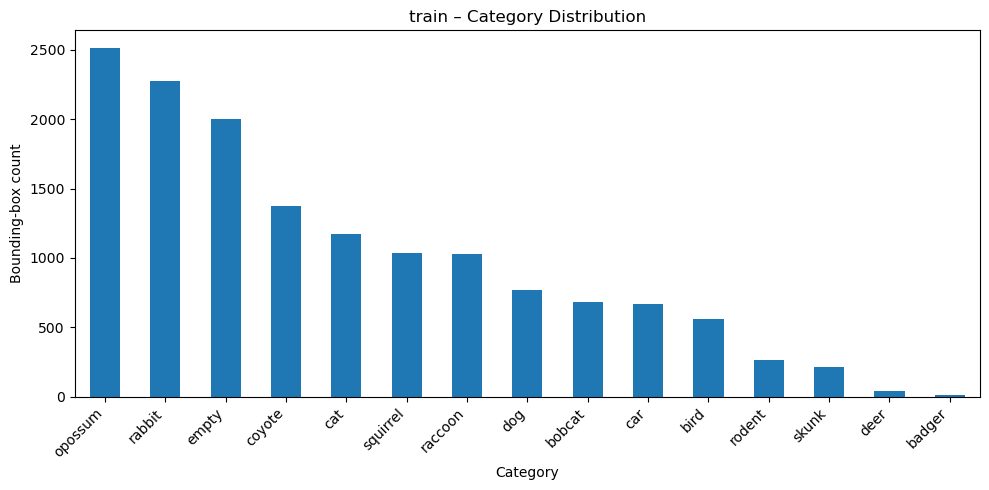

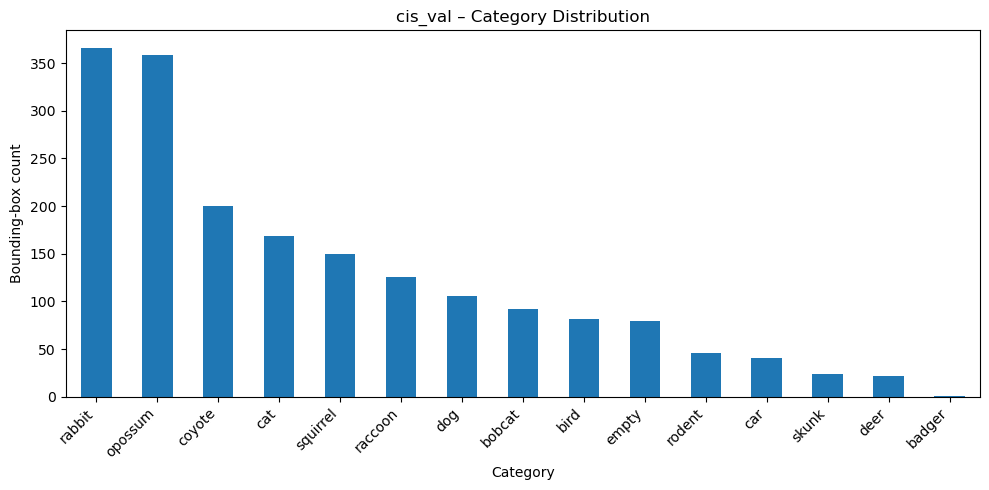

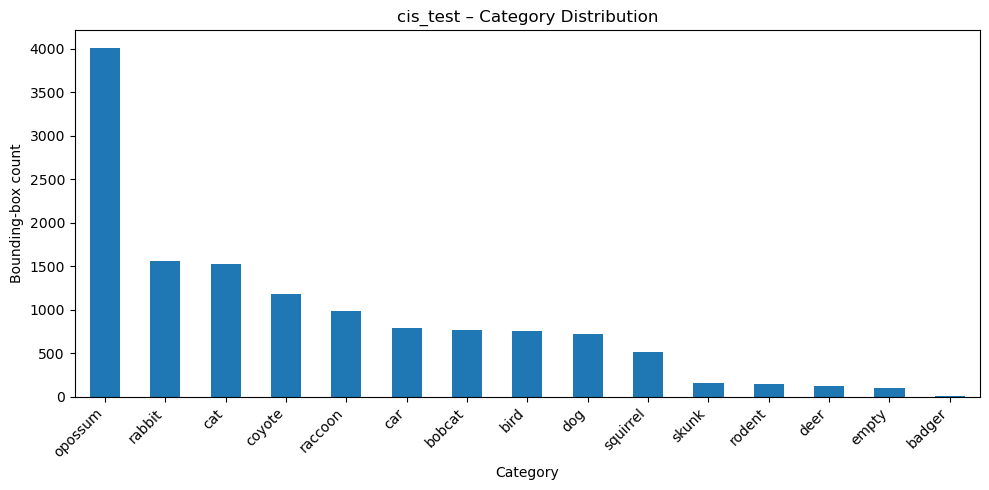

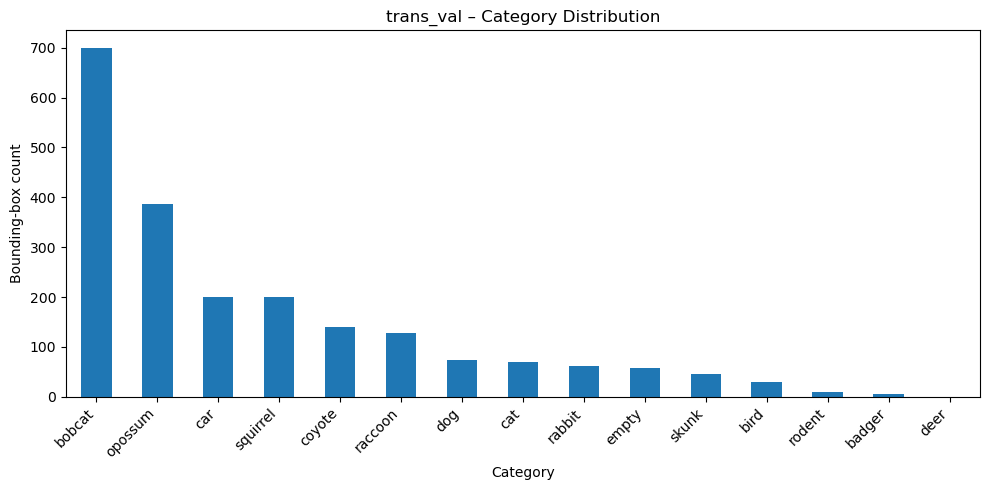

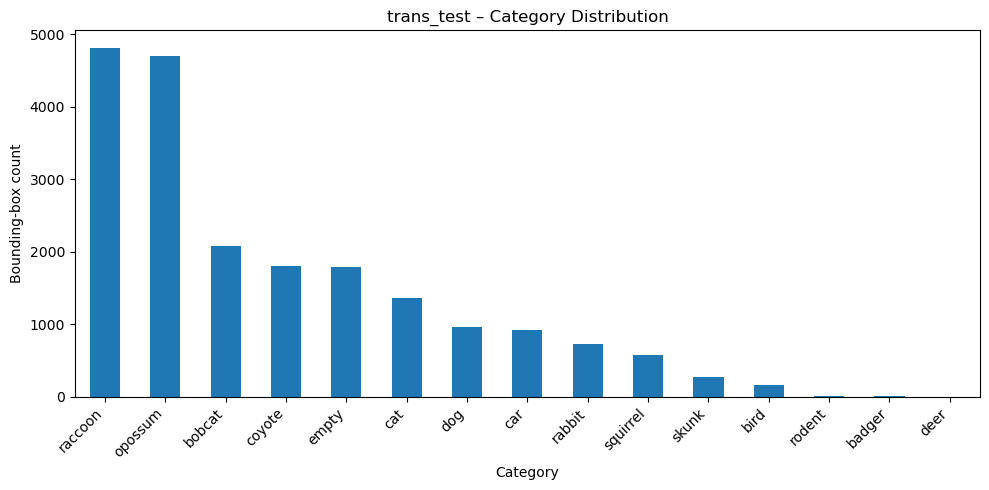

In [5]:
import matplotlib.pyplot as plt

splits = ["train", "cis_val", "cis_test", "trans_val", "trans_test"]

for split in splits:
    # plot categories sorted by descending count in this split
    (df_counts[split]
     .sort_values(ascending=False)
     .plot(kind="bar", figsize=(10, 5), title=f"{split} – Category Distribution"))

    plt.xlabel("Category")
    plt.ylabel("Bounding-box count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


# Seen locations in each split

In [ ]:
from itertools import combinations
# Collect the set of locations per split
loc_sets = {}
for split, p in json_paths.items():
    with p.open() as f:
        d = json.load(f)
    loc_sets[split] = {img["location"] for img in d["images"]}

#  Summary table: # unique locations in each split
locations = pd.DataFrame(
    {
        "split": list(loc_sets.keys()),
        "n_unique_locations": [len(s) for s in loc_sets.values()],
        "locations": [sorted(s) for s in loc_sets.values()],
    }
)
display(locations)

split  n_unique_locations                                    locations
0       train                  10  [33, 38, 43, 51, 61, 88, 90, 108, 115, 120]
1     cis_val                  10  [33, 38, 43, 51, 61, 88, 90, 108, 115, 120]
2    cis_test                  10  [33, 38, 43, 51, 61, 88, 90, 108, 115, 120]
3   trans_val                  10   [0, 7, 28, 40, 46, 78, 100, 105, 125, 130]
4  trans_test                  10   [0, 7, 28, 40, 46, 78, 100, 105, 125, 130]

## Final Duplication Check

In [ ]:
import collections, itertools

# load all splits
splits = {k: json.loads(p.read_text()) for k, p in json_paths.items()}

# duplicates inside each split 
dups_inside = {}
for name, coco in splits.items():
    ids  = [img["id"] for img in coco["images"]]
    dups = [id_ for id_, c in collections.Counter(ids).items() if c > 1]
    if dups:
        dups_inside[name] = dups

# duplicates across splits 
dups_across = {}
for a, b in itertools.combinations(splits.keys(), 2):
    ids_a = {img["id"] for img in splits[a]["images"]}
    ids_b = {img["id"] for img in splits[b]["images"]}
    overlap = ids_a & ids_b
    if overlap:
        dups_across[(a, b)] = overlap

# report
if not dups_inside and not dups_across:
    print("All image_id values are unique within and across splits.")
else:
    print("  Duplicate image_id issues detected\n")

    if dups_inside:
        for name, lst in dups_inside.items():
            print(f" • {name}: {len(lst)} duplicated IDs inside the split")

    if dups_across:
        for (a, b), lst in dups_across.items():
            print(f" • between {a} & {b}: {len(lst)} duplicated IDs")


All image_id values are unique within and across splits.


###  Image Resolution Distribution

In this section, we explore the dimensions of all images in the dataset.
Understanding the resolution helps us choose appropriate resizing or padding strategies during training and augmentation.


 Unique resolution combinations: 3

  Resolution 2048x1494: 12691 images
  Resolution 2048x1536: 1051 images
  Resolution 2560x1920: 352 images


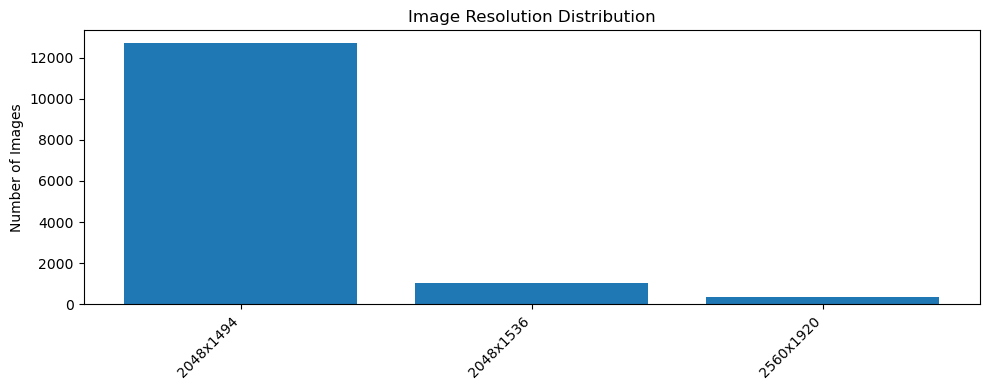

In [7]:
import json
from collections import Counter
import matplotlib.pyplot as plt

# Load merged dataset
with open(json_paths['train']) as f:
    data = json.load(f)

# Count (width, height) pairs
res_counter = Counter((img["width"], img["height"]) for img in data["images"])

# Print summary
print(f" Unique resolution combinations: {len(res_counter)}\n")
for (w, h), count in res_counter.most_common():
    print(f"  Resolution {w}x{h}: {count} images")

# Plot histogram of top resolutions
res_labels = [f"{w}x{h}" for (w, h) in res_counter]
res_counts = list(res_counter.values())

plt.figure(figsize=(10, 4))
plt.bar(res_labels, res_counts)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Images")
plt.title("Image Resolution Distribution")
plt.tight_layout()
plt.show()


The dataset includes 4 unique image resolutions, with the vast majority being 2048×1494. 
This indicates a strong consistency in image size, which simplifies model input resizing.

However, we also observe:
- A few higher-resolution images

Based on this, we may standardize all images to 1024×768 or 1280×960 using resizing + padding to maintain aspect ratio.


### Bounding Box Area and Aspect Ratio

In this section, we analyze the size and shape of animal bounding boxes in the dataset.
This helps us understand object scale, small object frequency, and spatial characteristics.


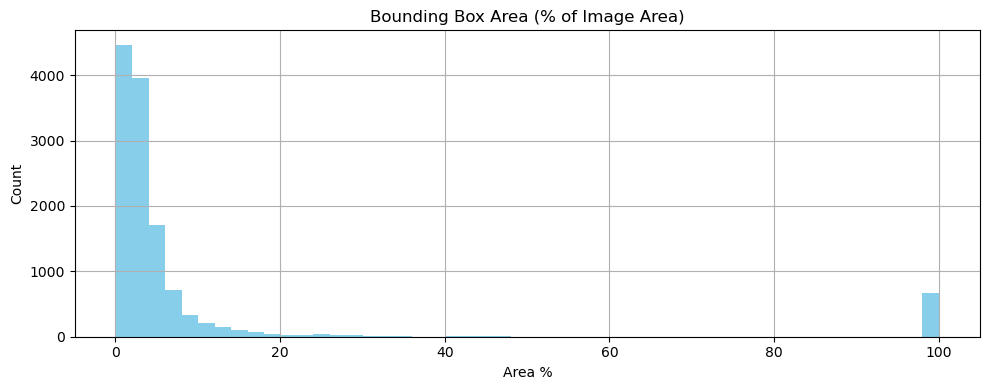

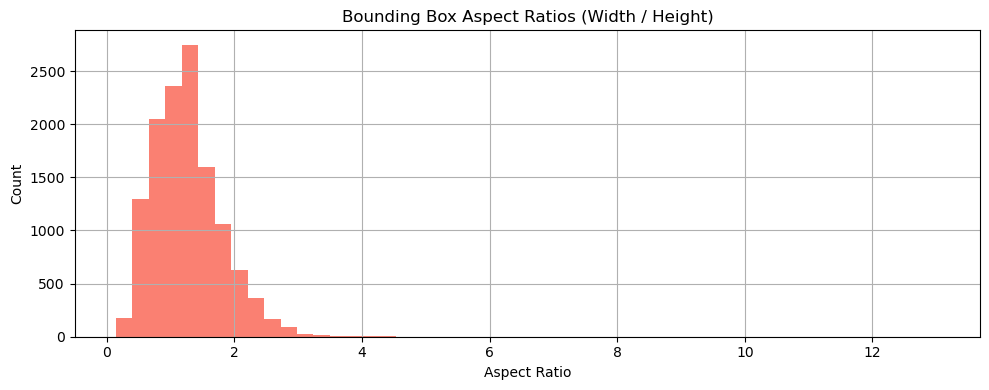

In [9]:

# Get image dimensions for area percentage calculation
image_dims = {img["id"]: (img["width"], img["height"]) for img in data["images"]}

bbox_areas = []
bbox_area_percent = []
bbox_aspect_ratios = []

for ann in data["annotations"]:
    if 'bbox' not in ann:
        continue 

    bbox = ann["bbox"]
    image_id = ann["image_id"]
    
    box_width, box_height = bbox[2], bbox[3]
    area = box_width * box_height
    aspect_ratio = box_width / box_height if box_height != 0 else 0
    
    # Get image area
    img_w, img_h = image_dims[image_id]
    img_area = img_w * img_h
    area_percent = (area / img_area) * 100
    
    # Store
    bbox_areas.append(area)
    bbox_area_percent.append(area_percent)
    bbox_aspect_ratios.append(aspect_ratio)

# --- Plot 1: Area percentage histogram
plt.figure(figsize=(10, 4))
plt.hist(bbox_area_percent, bins=50, color='skyblue')
plt.title("Bounding Box Area (% of Image Area)")
plt.xlabel("Area %")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Aspect ratio histogram
plt.figure(figsize=(10, 4))
plt.hist(bbox_aspect_ratios, bins=50, color='salmon')
plt.title("Bounding Box Aspect Ratios (Width / Height)")
plt.xlabel("Aspect Ratio")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


- Most bounding boxes occupy less than **5% of the image area**, indicating the need for small-object detection capability.
- Aspect ratios are generally compact (1.0–2.5), with a few long or thin boxes.
- These patterns suggest the need for:
  - Moderate to high input resolution
  - Cautious downscaling
  - Possibly tuning anchor sizes if using YOLO


### Species Distribution (Class Imbalance)

In this section, we analyze how frequently each animal class appears in the dataset.
This helps us identify class imbalance and determine if additional strategies (e.g., loss weighting or oversampling) are needed for rare species.


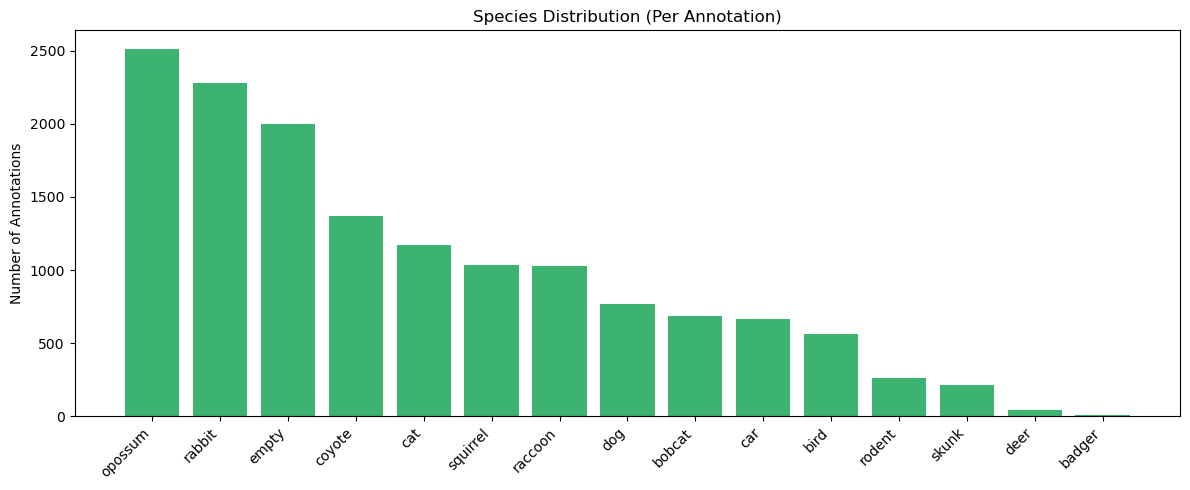

 Annotation counts per species:

  opossum        :   2514 (17.21%)
  rabbit         :   2278 (15.59%)
  empty          :   2000 (13.69%)
  coyote         :   1371 ( 9.38%)
  cat            :   1170 ( 8.01%)
  squirrel       :   1037 ( 7.10%)
  raccoon        :   1030 ( 7.05%)
  dog            :    769 ( 5.26%)
  bobcat         :    684 ( 4.68%)
  car            :    668 ( 4.57%)
  bird           :    560 ( 3.83%)
  rodent         :    264 ( 1.81%)
  skunk          :    214 ( 1.46%)
  deer           :     44 ( 0.30%)
  badger         :      9 ( 0.06%)

 Total annotations: 14612


In [10]:

# Map category_id to species name
cat_id_to_name = {cat["id"]: cat["name"] for cat in data["categories"]}

# Count each annotation by species
species_counts = Counter()

for ann in data["annotations"]:
    species_counts[cat_id_to_name[ann["category_id"]]] += 1

# Sort by count
species_counts = dict(species_counts.most_common())

# --- Plot
plt.figure(figsize=(12, 5))
plt.bar(species_counts.keys(), species_counts.values(), color="mediumseagreen")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Annotations")
plt.title("Species Distribution (Per Annotation)")
plt.tight_layout()
plt.show()

# --- Print numeric summary
print(" Annotation counts per species:\n")
total = sum(species_counts.values())
for species, count in species_counts.items():
    percent = (count / total) * 100
    print(f"  {species:15s}: {count:6d} ({percent:5.2f}%)")

print(f"\n Total annotations: {total}")


The dataset is highly imbalanced. Opossums, rabbits, and empty frames dominate while deer and badger are nearly absent.

- The top five classes contribute roughly 66 % of all annotations.  
- Tail classes (deer, badger, rodent, skunk) together account for less than 2 % of the data.  
- Empty images form 14 % of the labels, useful for controlling false positives.

Modelling and augmentation actions:

- Use class-balanced sampling and a long-tail-friendly loss.  
- Apply targeted augmentation (copy-paste or mosaic) to deer, badger, rodent, and skunk.
- Evaluate with per-class and macro metrics so tail performance is visible.

### Image & Bounding-Box Overview  

The code block computes four headline statistics for the current COCO-style split:

These figures help us  
- check overall annotation coverage (e.g., how sparse the labels are),  
- gauge scene complexity (single-object vs. multi-object prevalence),  
- and plan sampling or loss weighting strategies for training.


In [13]:

# --- Basic counts ---
total_images = len(data["images"])
total_bboxes = len(data["annotations"])

# Get image IDs used in annotations
annotated_image_ids = [ann["image_id"] for ann in data["annotations"]]
unique_annotated_image_ids = set(annotated_image_ids)
num_annotated_images = len(unique_annotated_image_ids)

# Count multi-bbox images
num_multi_bbox_images = total_bboxes - num_annotated_images

# --- Percentages ---
pct_annotated_images = (num_annotated_images / total_images) * 100
pct_multi_bbox_images = (num_multi_bbox_images / total_images) * 100

# --- Output ---
print("Dataset Composition Summary\n")
print(f" Total images                  : {total_images}")
print(f" Annotated images              : {num_annotated_images} ({pct_annotated_images:.2f}%)")
print(f" Total bounding boxes (bboxes) : {total_bboxes}")
print(f" Images with >1 bbox           : {num_multi_bbox_images} ({pct_multi_bbox_images:.2f}%)")





Dataset Composition Summary

 Total images                  : 14094
 Annotated images              : 14094 (100.00%)
 Total bounding boxes (bboxes) : 14612
 Images with >1 bbox           : 518 (3.68%)


Key observations  
* Every image has at least one annotation, so no explicit “empty” frames exist in this split.  
* Multi-object scenes are rare (≈ 4 % of images), implying that most frames contain a single animal or car.  
* The small gap between “total images” and “total boxes” suggests a near 1-to-1 mapping of image → object, which simplifies NMS and per-image evaluation but may under-represent crowded scenes.


### Temporal Patterns in Image Captures

In this section, we analyze the time-related patterns in the dataset, including hour-of-day and month-of-year distributions. 
This can highlight potential biases in capture timing (e.g., mostly nighttime or daytime images), which may impact model generalization.


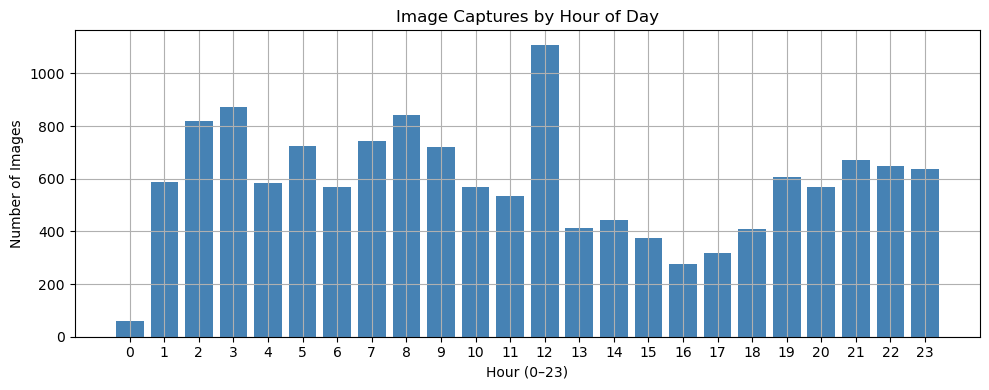

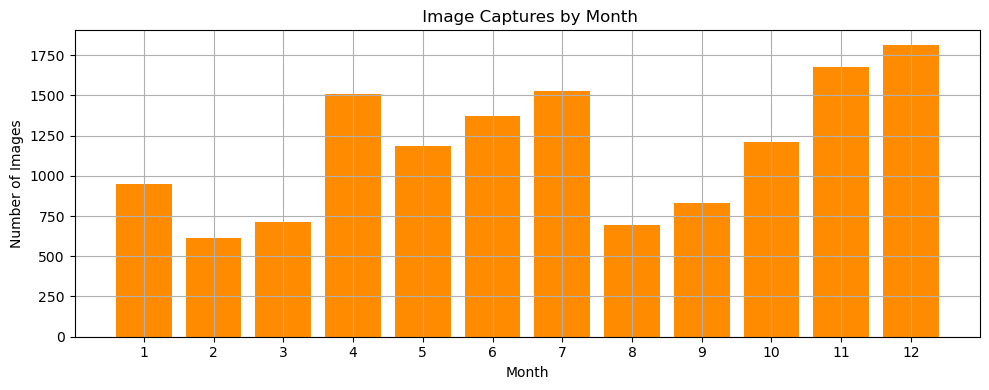

In [14]:
from datetime import datetime

# Parse capture time per image
hour_counts = Counter()
month_counts = Counter()

for img in data["images"]:
    try:
        dt = datetime.strptime(img["date_captured"], "%Y-%m-%d %H:%M:%S")
        hour_counts[dt.hour] += 1
        month_counts[dt.month] += 1
    except Exception as e:
        continue  # skip malformed dates

# --- Plot: Hour of Day
hours = list(range(24))
hour_freq = [hour_counts[h] for h in hours]

plt.figure(figsize=(10, 4))
plt.bar(hours, hour_freq, color="steelblue")
plt.title("Image Captures by Hour of Day")
plt.xlabel("Hour (0–23)")
plt.ylabel("Number of Images")
plt.xticks(hours)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot: Month
months = list(range(1, 13))
month_freq = [month_counts[m] for m in months]

plt.figure(figsize=(10, 4))
plt.bar(months, month_freq, color="darkorange")
plt.title(" Image Captures by Month")
plt.xlabel("Month")
plt.ylabel("Number of Images")
plt.xticks(months)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Hour-of-day pattern  
- Image frequency climbs after sunrise, peaks sharply at 12 h, then tapers through the afternoon.  
- Midnight to 01 h has almost no activity, confirming a strong daytime bias.  


#### Month-of-year pattern  
- December is the busiest month (≈ 1 800 images), followed by November and July; February and August are the sparsest.  
- Captures rise in mid-spring, dip in late summer, and surge again toward year-end, indicating seasonal skew.  



### Species Co-Occurrence Matrix

This matrix shows how often pairs of species appear together in the same image.
It reveals inter-species patterns and visual complexity.


C:\Users\cilek\AppData\Local\Temp\ipykernel_2656\1978586483.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = pd.DataFrame(index=species_names, columns=species_names).fillna(0)


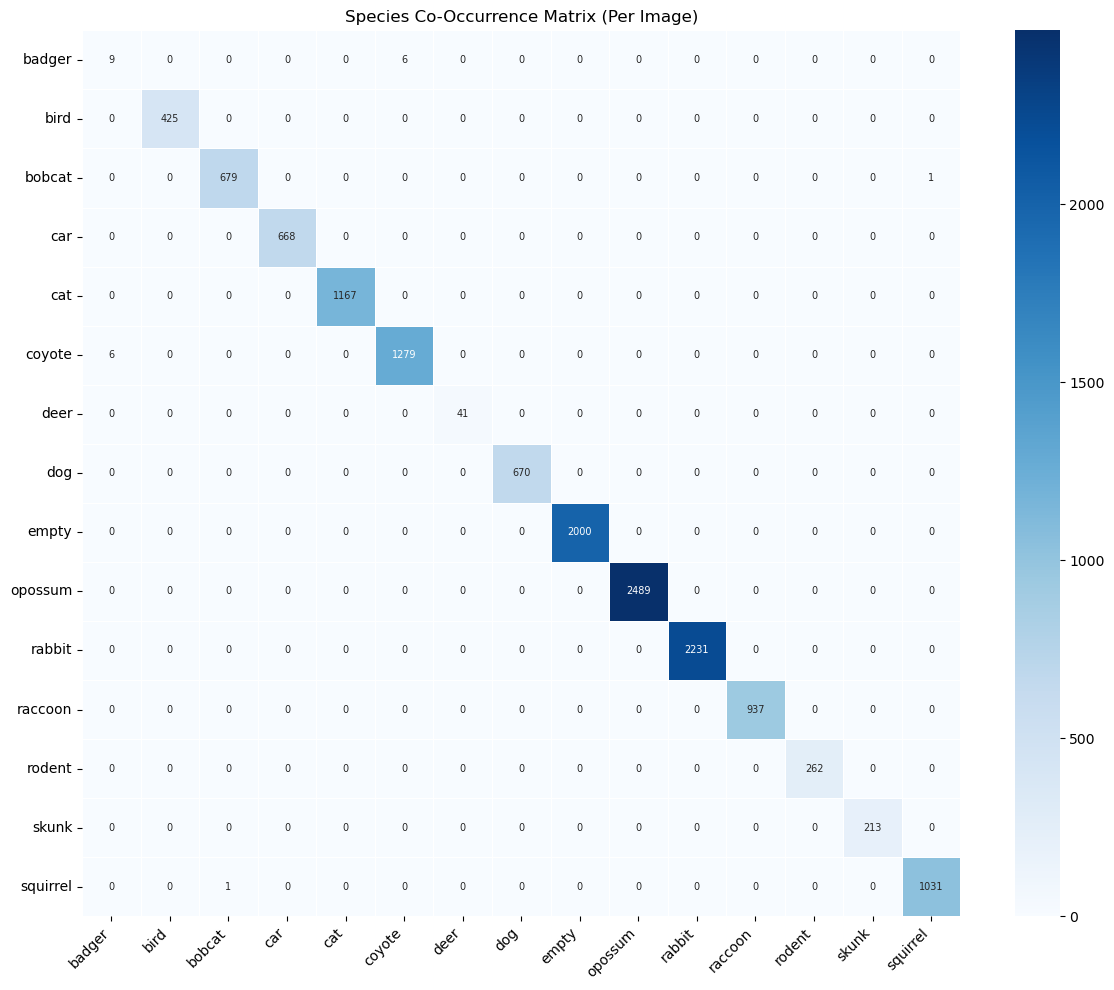

In [ ]:
from collections import defaultdict
import pandas as pd
import seaborn as sns

# Map category ID to name
cat_id_to_name = {cat["id"]: cat["name"] for cat in data["categories"]}

# image_id - set of species names
image_species_map = defaultdict(set)
for ann in data["annotations"]:
    species_name = cat_id_to_name[ann["category_id"]]
    image_species_map[ann["image_id"]].add(species_name)

# Count species co-occurrence (1 per species per image)
cooccurrence = defaultdict(lambda: defaultdict(int))

for species_set in image_species_map.values():
    species = sorted(list(species_set))
    for i in range(len(species)):
        for j in range(i, len(species)):
            sp1, sp2 = species[i], species[j]
            cooccurrence[sp1][sp2] += 1
            if sp1 != sp2:
                cooccurrence[sp2][sp1] += 1  # ensure symmetry

#  Build matrix
species_names = sorted(cat_id_to_name.values())
matrix = pd.DataFrame(index=species_names, columns=species_names).fillna(0)

for sp1 in species_names:
    for sp2 in species_names:
        matrix.loc[sp1, sp2] = cooccurrence[sp1][sp2]

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    matrix.astype(int),
    cmap="Blues",
    linewidths=0.5,
    annot=True,
    fmt="d",
    annot_kws={"size": 7}
)
plt.title("Species Co-Occurrence Matrix (Per Image)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Species co-occurrence (per image)

The heat-map is almost perfectly diagonal: each image contains only one labelled species. Off-diagonal counts are either zero or negligible (coyote-badger=6 frames, squirrel-bobcat=1 frame), likely annotation noise.

Implications  
- The detector rarely faces true multi-species scenes; class confusion will stem from visual similarity, not simultaneous presence.  
- We can treat training as a single-label detection problem—no need for multi-label loss functions.  
- Those few off-diagonal cases could be inspected manually or ignored without affecting class-balance.


### Visual Inspection of Annotated and Empty Images

We randomly sample a few images from the dataset and visualize:
- Annotated images with bounding boxes
- Empty images (no animals)

This helps us check for annotation quality, object visibility, and scene variability.


Annotated examples:


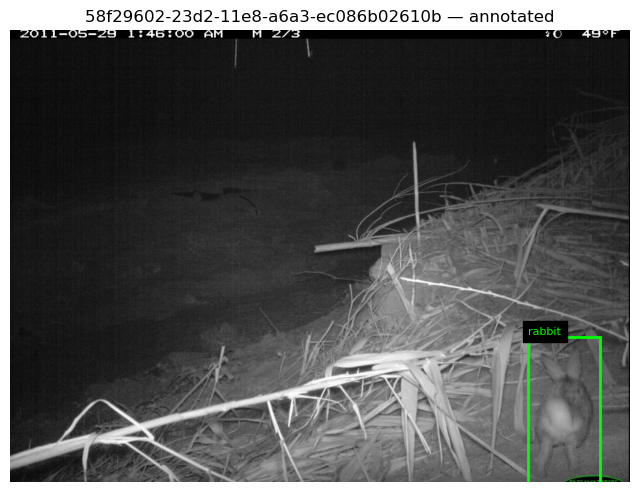

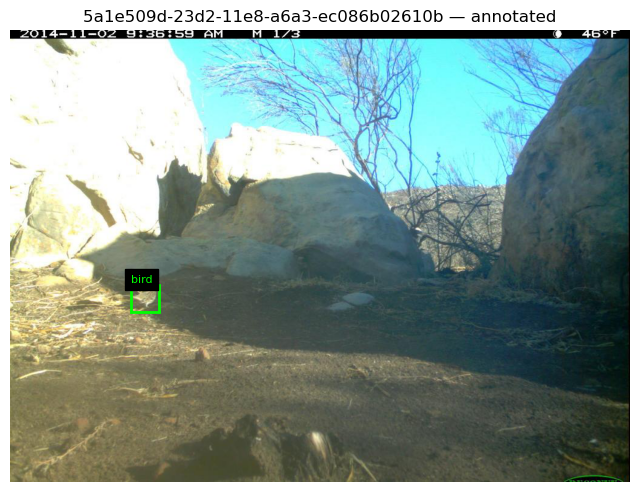

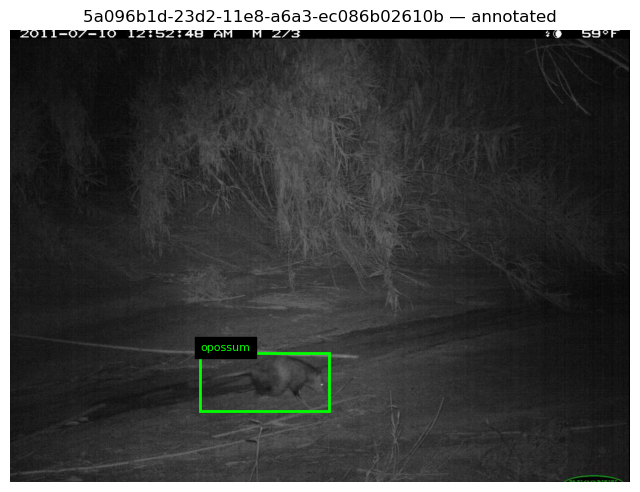

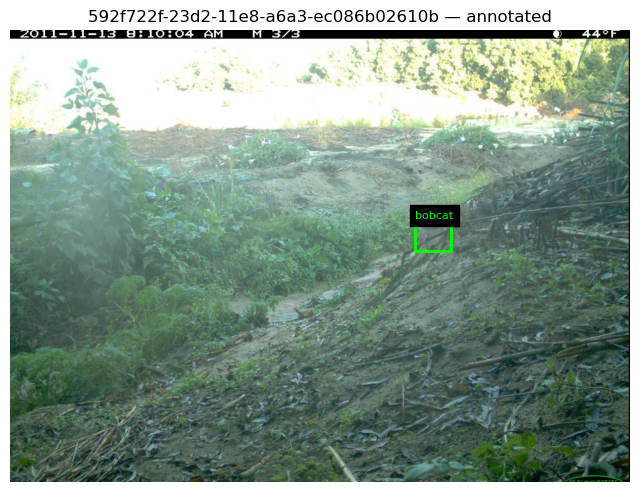

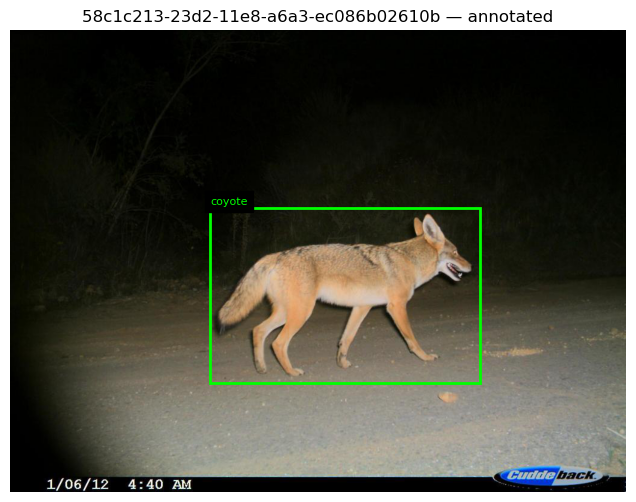


Empty examples:


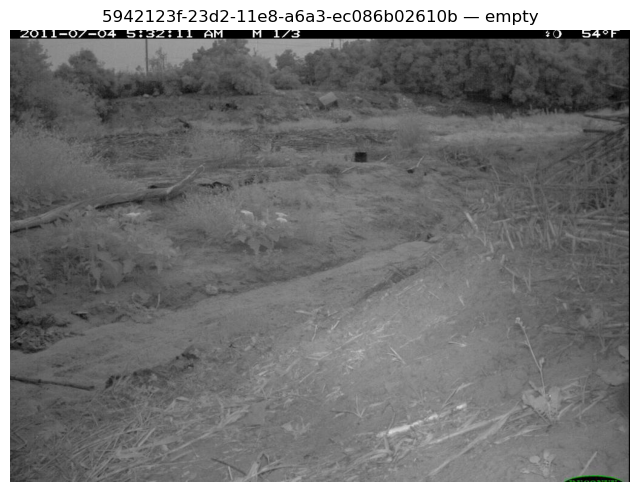

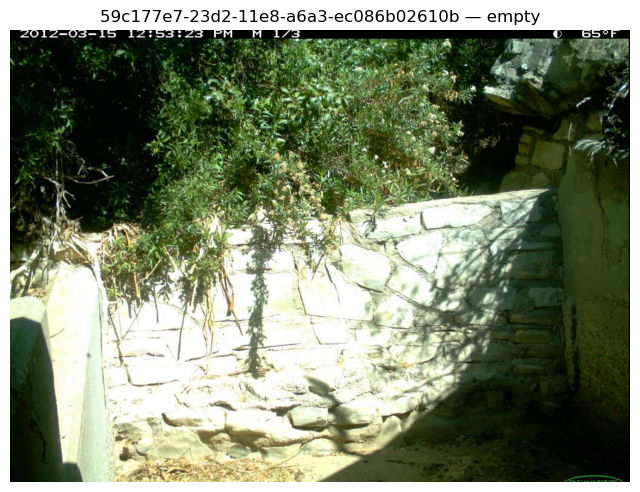

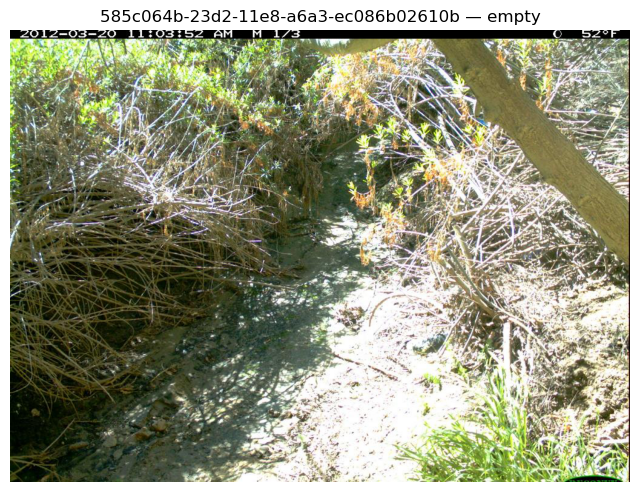

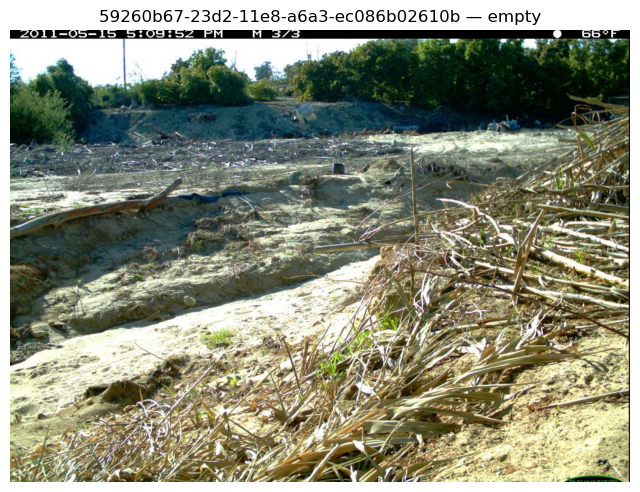

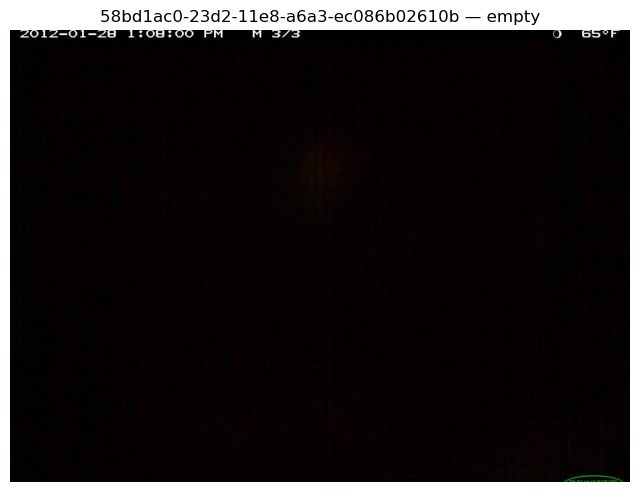

In [ ]:
import os, random, numpy as np, cv2, matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.patches import Rectangle
from PIL import Image, ImageOps

# ------------------------------------------------------------------
image_root = "../data/images/"   # folder with all JPEGs


# index annotations by image_id
ann_by_image = defaultdict(list)
for ann in data["annotations"]:
    if "bbox" in ann:
        ann_by_image[ann["image_id"]].append(ann)

def load_rgb(path):
    """Load JPEG, apply EXIF rotation, return RGB np.array."""
    img = ImageOps.exif_transpose(Image.open(path))
    return np.array(img)

def plot_image_with_boxes(image_id, title=""):
    # metadata + file
    meta = next(img for img in data["images"] if img["id"] == image_id)
    file_path = os.path.join(image_root, meta["file_name"])
    rgb = load_rgb(file_path)

    # scale factors: JSON coords to displayed pixels
    H_disk, W_disk = rgb.shape[:2]
    sx, sy = W_disk / meta["width"], H_disk / meta["height"]

    plt.figure(figsize=(8, 6))
    plt.imshow(rgb)
    ax = plt.gca()

    for ann in ann_by_image.get(image_id, []):
        x, y, w, h = [v * s for v, s in zip(ann["bbox"], (sx, sy, sx, sy))]
        ax.add_patch(Rectangle((x, y), w, h,
                               linewidth=2, edgecolor="lime", facecolor="none"))
        ax.text(x, y - 5, cat_id_to_name[ann["category_id"]],
                color="lime", fontsize=8, backgroundcolor="black")

    plt.title(title)
    plt.axis("off")
    plt.show()

# ------------------------------------------------------------------
# show 5 annotated and 5 empty images
annotated_ids = list(ann_by_image.keys())
empty_ids     = [img["id"] for img in data["images"] if img["id"] not in ann_by_image]

print("Annotated examples:")
for img_id in random.sample(annotated_ids, 5):
    plot_image_with_boxes(img_id, title=f"{img_id} — annotated")

print("\nEmpty examples:")
for img_id in random.sample(empty_ids, 5):
    plot_image_with_boxes(img_id, title=f"{img_id} — empty")


### RGB Channel Histograms

We examine pixel intensity distributions across R, G, and B channels for a few images.
This helps us detect exposure or lighting issues, and motivates color-related augmentations.


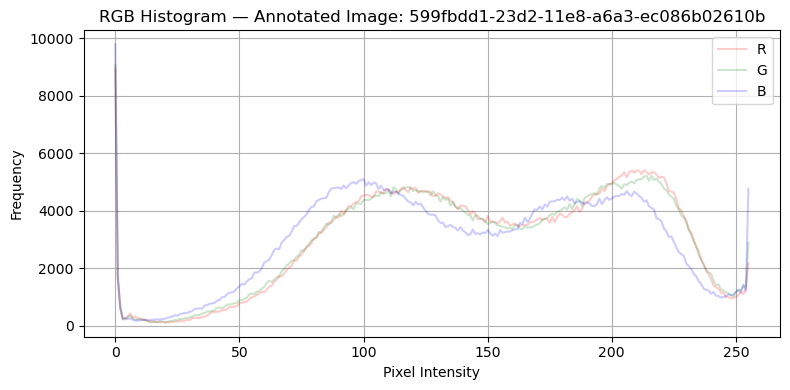

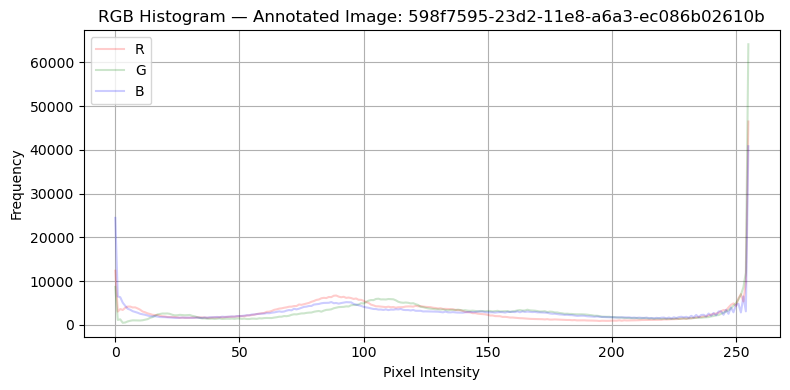

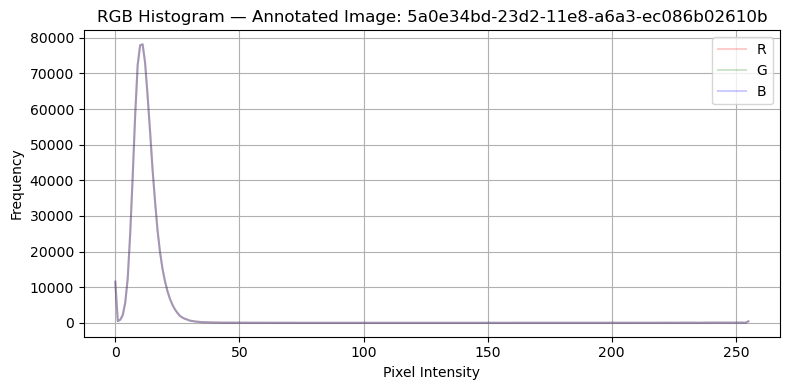

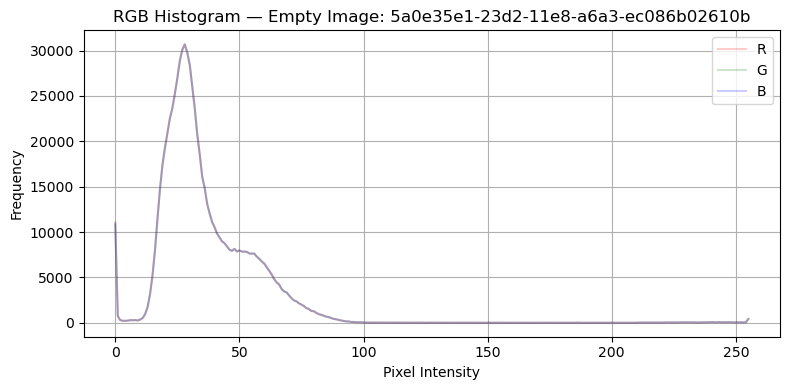

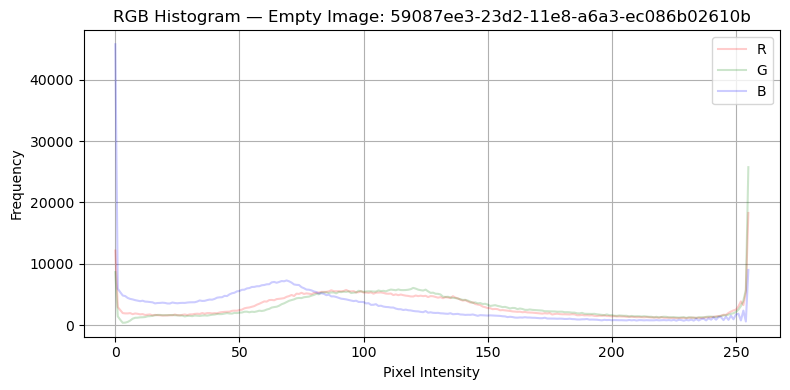

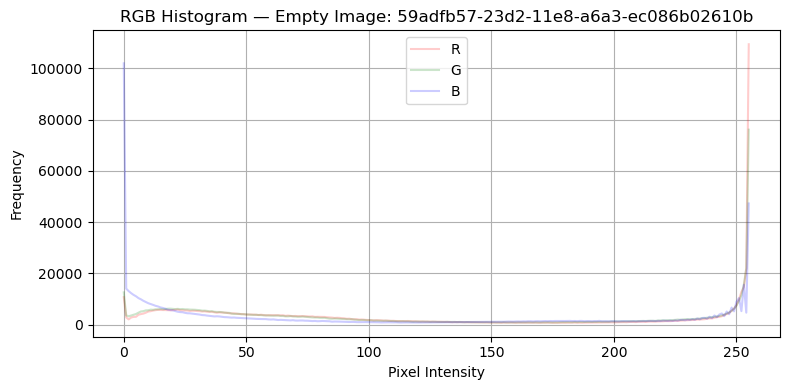

In [ ]:

# Function to plot RGB histogram for a given image
def plot_rgb_histogram(image_id, title=""):
    img_meta = next(img for img in data["images"] if img["id"] == image_id)
    file_path = os.path.join(image_root, img_meta["file_name"])
    
    img = cv2.imread(file_path)
    if img is None:
        print(f" Could not load {file_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Plot histogram
    plt.figure(figsize=(8, 4))
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        plt.plot(hist, color=color,alpha=0.5, linewidth=1.5, label=f"{color.upper()}")
    plt.title(f"RGB Histogram — {title}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Sample annotated and empty images
sample_annotated = random.sample(annotated_ids, 3)
sample_empty = random.sample(empty_ids, 3)

# Plot for annotated
for img_id in sample_annotated:
    plot_rgb_histogram(img_id, title=f"Annotated Image: {img_id}")

# Plot for empty
for img_id in sample_empty:
    plot_rgb_histogram(img_id, title=f"Empty Image: {img_id}")


The RGB histograms reveal a variety of lighting conditions:

- Annotated images generally have broad distributions with balanced channels.
- Empty images show more extreme lighting — often low-light, blue-heavy, or overexposed.

To handle this:
- We plan to use **brightness/contrast jitter**, **color channel shift**, and optionally **histogram equalization**.
- This will improve generalization across lighting conditions and prevent overfitting to high-exposure daytime scenes.


### Brightness Distribution

We compute the average pixel brightness for a sample of annotated and empty images.
This reveals how many images are dark, well-lit, or overexposed — and motivates brightness-based augmentations.


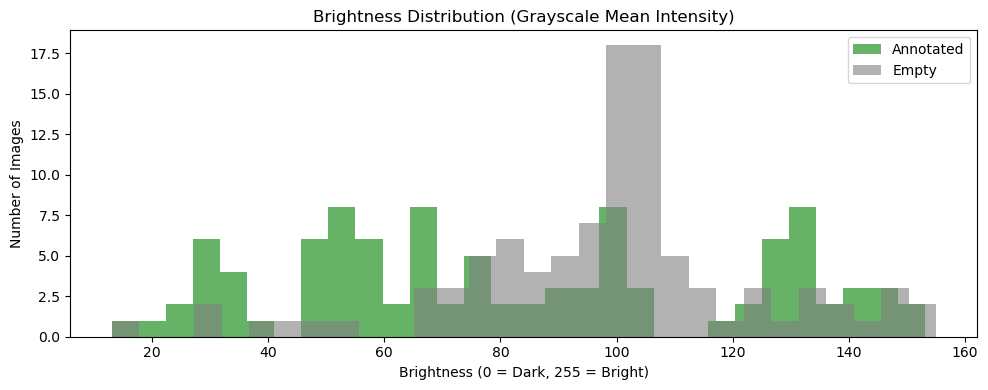

In [ ]:
import numpy as np

# compute brightness (mean pixel intensity)
def compute_brightness(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    return np.mean(img)

# Sample annotated and empty image IDs
sample_ids = random.sample(annotated_ids, 100) + random.sample(empty_ids, 100)

brightness_values = []
labels = []

for img_id in sample_ids:
    img_meta = next(img for img in data["images"] if img["id"] == img_id)
    file_path = os.path.join(image_root, img_meta["file_name"])
    brightness = compute_brightness(file_path)
    if brightness is not None:
        brightness_values.append(brightness)
        labels.append("annotated" if img_id in ann_by_image else "empty")

#  Plot
plt.figure(figsize=(10, 4))
plt.hist(
    [b for b, l in zip(brightness_values, labels) if l == "annotated"],
    bins=30, alpha=0.6, label="Annotated", color="green"
)
plt.hist(
    [b for b, l in zip(brightness_values, labels) if l == "empty"],
    bins=30, alpha=0.6, label="Empty", color="gray"
)
plt.title("Brightness Distribution (Grayscale Mean Intensity)")
plt.xlabel("Brightness (0 = Dark, 255 = Bright)")
plt.ylabel("Number of Images")
plt.legend()
plt.tight_layout()
plt.show()



- Empty images are generally well-lit, with brightness values clustering between 80–110.
- Annotated images show a much wider brightness range:
  - Some dark (nighttime, low exposure)
  - Some very bright (overexposed scenes)

To improve robustness, we plan to use:
- Brightness and contrast jitter,
- Possibly histogram equalization or CLAHE for darker samples,
- This will help the model generalize across lighting extremes.


### Blurriness (Sharpness) Distribution

We calculate the variance of the Laplacian for a set of images to measure sharpness.
Lower values indicate more blur; higher values indicate sharper images.


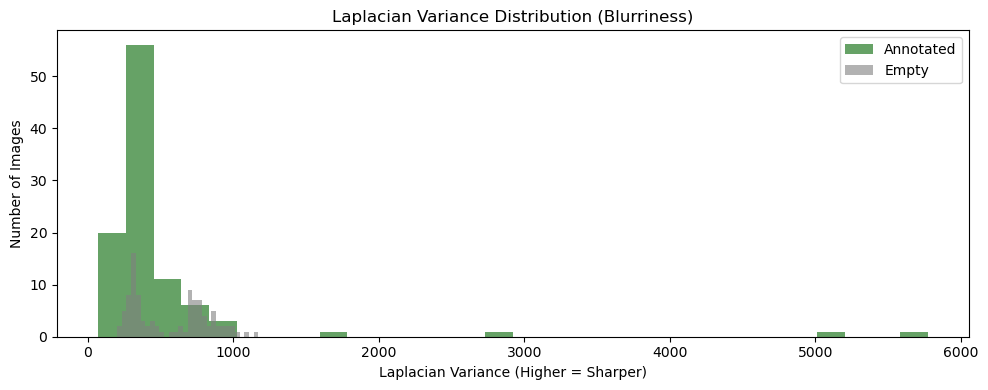

In [10]:
# Compute Laplacian variance (blurriness)
def compute_blurriness(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    return cv2.Laplacian(img, cv2.CV_64F).var()

# Sample 100 annotated + 100 empty images
sample_ids = random.sample(annotated_ids, 100) + random.sample(empty_ids, 100)

blur_values = []
labels = []

for img_id in sample_ids:
    img_meta = next(img for img in data["images"] if img["id"] == img_id)
    file_path = os.path.join(image_root, img_meta["file_name"])
    blur = compute_blurriness(file_path)
    if blur is not None:
        blur_values.append(blur)
        labels.append("annotated" if img_id in ann_by_image else "empty")

# Plot
plt.figure(figsize=(10, 4))
plt.hist(
    [b for b, l in zip(blur_values, labels) if l == "annotated"],
    bins=30, alpha=0.6, label="Annotated", color="darkgreen"
)
plt.hist(
    [b for b, l in zip(blur_values, labels) if l == "empty"],
    bins=30, alpha=0.6, label="Empty", color="gray"
)
plt.title("Laplacian Variance Distribution (Blurriness)")
plt.xlabel("Laplacian Variance (Higher = Sharper)")
plt.ylabel("Number of Images")
plt.legend()
plt.tight_layout()
plt.show()



- Most images have Laplacian variance in the 200–800 range, indicating reasonably sharp captures.
- A few very sharp images (>2000) exist but are rare.
- Both annotated and empty images share similar sharpness distributions.

While blurriness is not a major concern, we will include **random motion blur** and **mild Gaussian blur** in augmentation to improve robustness to movement or camera shake.


## Exploratory Data Analysis (EDA) Summary & Modeling Plan

This section summarizes key insights from our comprehensive visual and annotation-based EDA of the Caltech Camera Traps dataset, and how they directly inform our modeling and augmentation choices.


### Object & Annotation Patterns

- **Bounding boxes**: Most are small, covering <5% of image area.
- **Aspect ratios**: Compact to moderate; rare extreme elongations.
- **No species co-occurrence**: All multi-object images contain only **one species**.

A **single-label detection/classification pipeline** is appropriate; no multi-label output is required.

---

###  Species Distribution

- Long-tailed distribution: opossum, raccoon, coyote dominate.
- Rare species (e.g., `bat`, `badger`, `insect`) are nearly absent in training.
- Some species appear **only in test** due to location-based split.

 Calls for class re-weighting, augmentation for rare species, and motivates a **zero-shot classifier**.

---

### Temporal & Spatial Biases

- **Most images captured between 10:00–14:00** → daytime bias.
- **May-heavy** image distribution (over 50,000 in a single month).
- Imbalance across camera locations.

 Temporal augmentations (brightness/contrast, time-of-day simulation) recommended.

---

### Visual Quality Insights

- **Brightness**: Wide spread across both annotated and empty images.
- **Blurriness**: Most images moderately sharp; some motion blur.
- **RGB channel bias**: Blue-heavy in some night/IR captures.
- **Histograms**: Exposed lighting imbalance and low contrast in certain scenes.

Motivate:
- Brightness/contrast jitter
- Gaussian + motion blur augmentation
- Color jitter & channel shift
- CLAHE for low-light cases

---

## Modeling Plan

We evaluate four modeling configurations: two single-stage detectors and two two-stage pipelines.

### Model 1: YOLOv8 (Single-Stage)
- Joint detection and classification in a single model
- Trained end-to-end to detect **all species categories**
- Serves as a strong, fast baseline

### Model 2: MegaDetector v6 (Single-Stage)
- Pretrained object detector with full category support
- Demonstrates **transfer learning** performance without fine-tuning
- Evaluates the generalization of MegaDetector on our data

---

### Model 3: MegaDetector v6 (2-Class) → EfficientNet Classifier
- **Step 1:** MegaDetector v6 trained to detect only **animal vs vehicle**
- **Step 2:** Crop detected animals and classify species using an **EfficientNet** model
- Modular and interpretable two-stage pipeline

### Model 4: MegaDetector v6 (2-Class) → ConvNeXt Classifier
- Same detection stage as Model 3 (animal vs vehicle)
- Species classification performed using a **ConvNeXt** model
- Allows comparison of ConvNeXt vs EfficientNet on identical crops


### Augmentation Strategy (Driven by EDA)

| Goal                  | Technique                                 |
|-----------------------|-------------------------------------------|
| Lighting variation    | Brightness/contrast jitter, gamma shifts  |
| Night/day simulation  | Histogram equalization, CLAHE             |
| Small object focus    | Random zoom-in, random crop               |
| Blur handling         | Motion blur, Gaussian blur                |
| Class imbalance       | Oversampling rare species, re-weighting   |
| Sensor variability    | Color jitter, channel shifting            |

---

### Evaluation Plan

- Per-class accuracy and F1
- Cross-location generalization (cis vs trans)
- Ablation studies: with/without augmentation

